In [19]:
import osmnx as ox
G = ox.graph_from_place('Sutherland Shire Council', network_type='drive')

In [20]:
print("node count:", len(G.nodes()))
print("edge count:", len(G.edges()))

node count: 5516
edge count: 12320


In [21]:
# find nearest node
station_st_node_id = ox.distance.nearest_nodes(G, [151.014898], [-34.06714])[0]
station_st_node_id

268185063

In [22]:
# find node by ID and show its properties
G.nodes.get(station_st_node_id)

# find its neighbouring nodes
list(G.neighbors(station_st_node_id))

import json
# show edge attributes
for edge in G.out_edges(station_st_node_id, data=True):
    print("\n=== Edge ====")
    print("Source and target node ID:", edge[:2])
    edge_attributes = edge[2]
    # remove geometry object from output
    edge_attributes_wo_geometry = {i:edge_attributes[i] for i in edge_attributes if i!='geometry'}
    print("Edge attributes:", json.dumps(edge_attributes_wo_geometry, indent=4))


=== Edge ====
Source and target node ID: (268185063, 1839271812)
Edge attributes: {
    "osmid": 173099486,
    "name": "Station Street",
    "highway": "unclassified",
    "maxspeed": "50",
    "oneway": false,
    "length": 101.788
}

=== Edge ====
Source and target node ID: (268185063, 668727077)
Edge attributes: {
    "osmid": 356065478,
    "oneway": true,
    "lanes": "3",
    "ref": "A1",
    "name": "Railway Parade",
    "highway": "trunk",
    "maxspeed": "70",
    "length": 96.398
}


In [23]:
# impute edge (driving) speeds and calculate edge traversal times
G = ox.add_edge_speeds(G)
G = ox.add_edge_travel_times(G)

In [24]:
for edge in G.out_edges(station_st_node_id, data=True):
    print("\n=== Edge ====")
    print("Source and target node ID:", edge[:2])
    edge_attributes = edge[2]
    # remove geometry object from output
    edge_attributes_wo_geometry = {i:edge_attributes[i] for i in edge_attributes if i!='geometry'}
    print("Edge attributes:", json.dumps(edge_attributes_wo_geometry, indent=4))


=== Edge ====
Source and target node ID: (268185063, 1839271812)
Edge attributes: {
    "osmid": 173099486,
    "name": "Station Street",
    "highway": "unclassified",
    "maxspeed": "50",
    "oneway": false,
    "length": 101.788,
    "speed_kph": 50.0,
    "travel_time": 7.3
}

=== Edge ====
Source and target node ID: (268185063, 668727077)
Edge attributes: {
    "osmid": 356065478,
    "oneway": true,
    "lanes": "3",
    "ref": "A1",
    "name": "Railway Parade",
    "highway": "trunk",
    "maxspeed": "70",
    "length": 96.398,
    "speed_kph": 70.0,
    "travel_time": 5.0
}


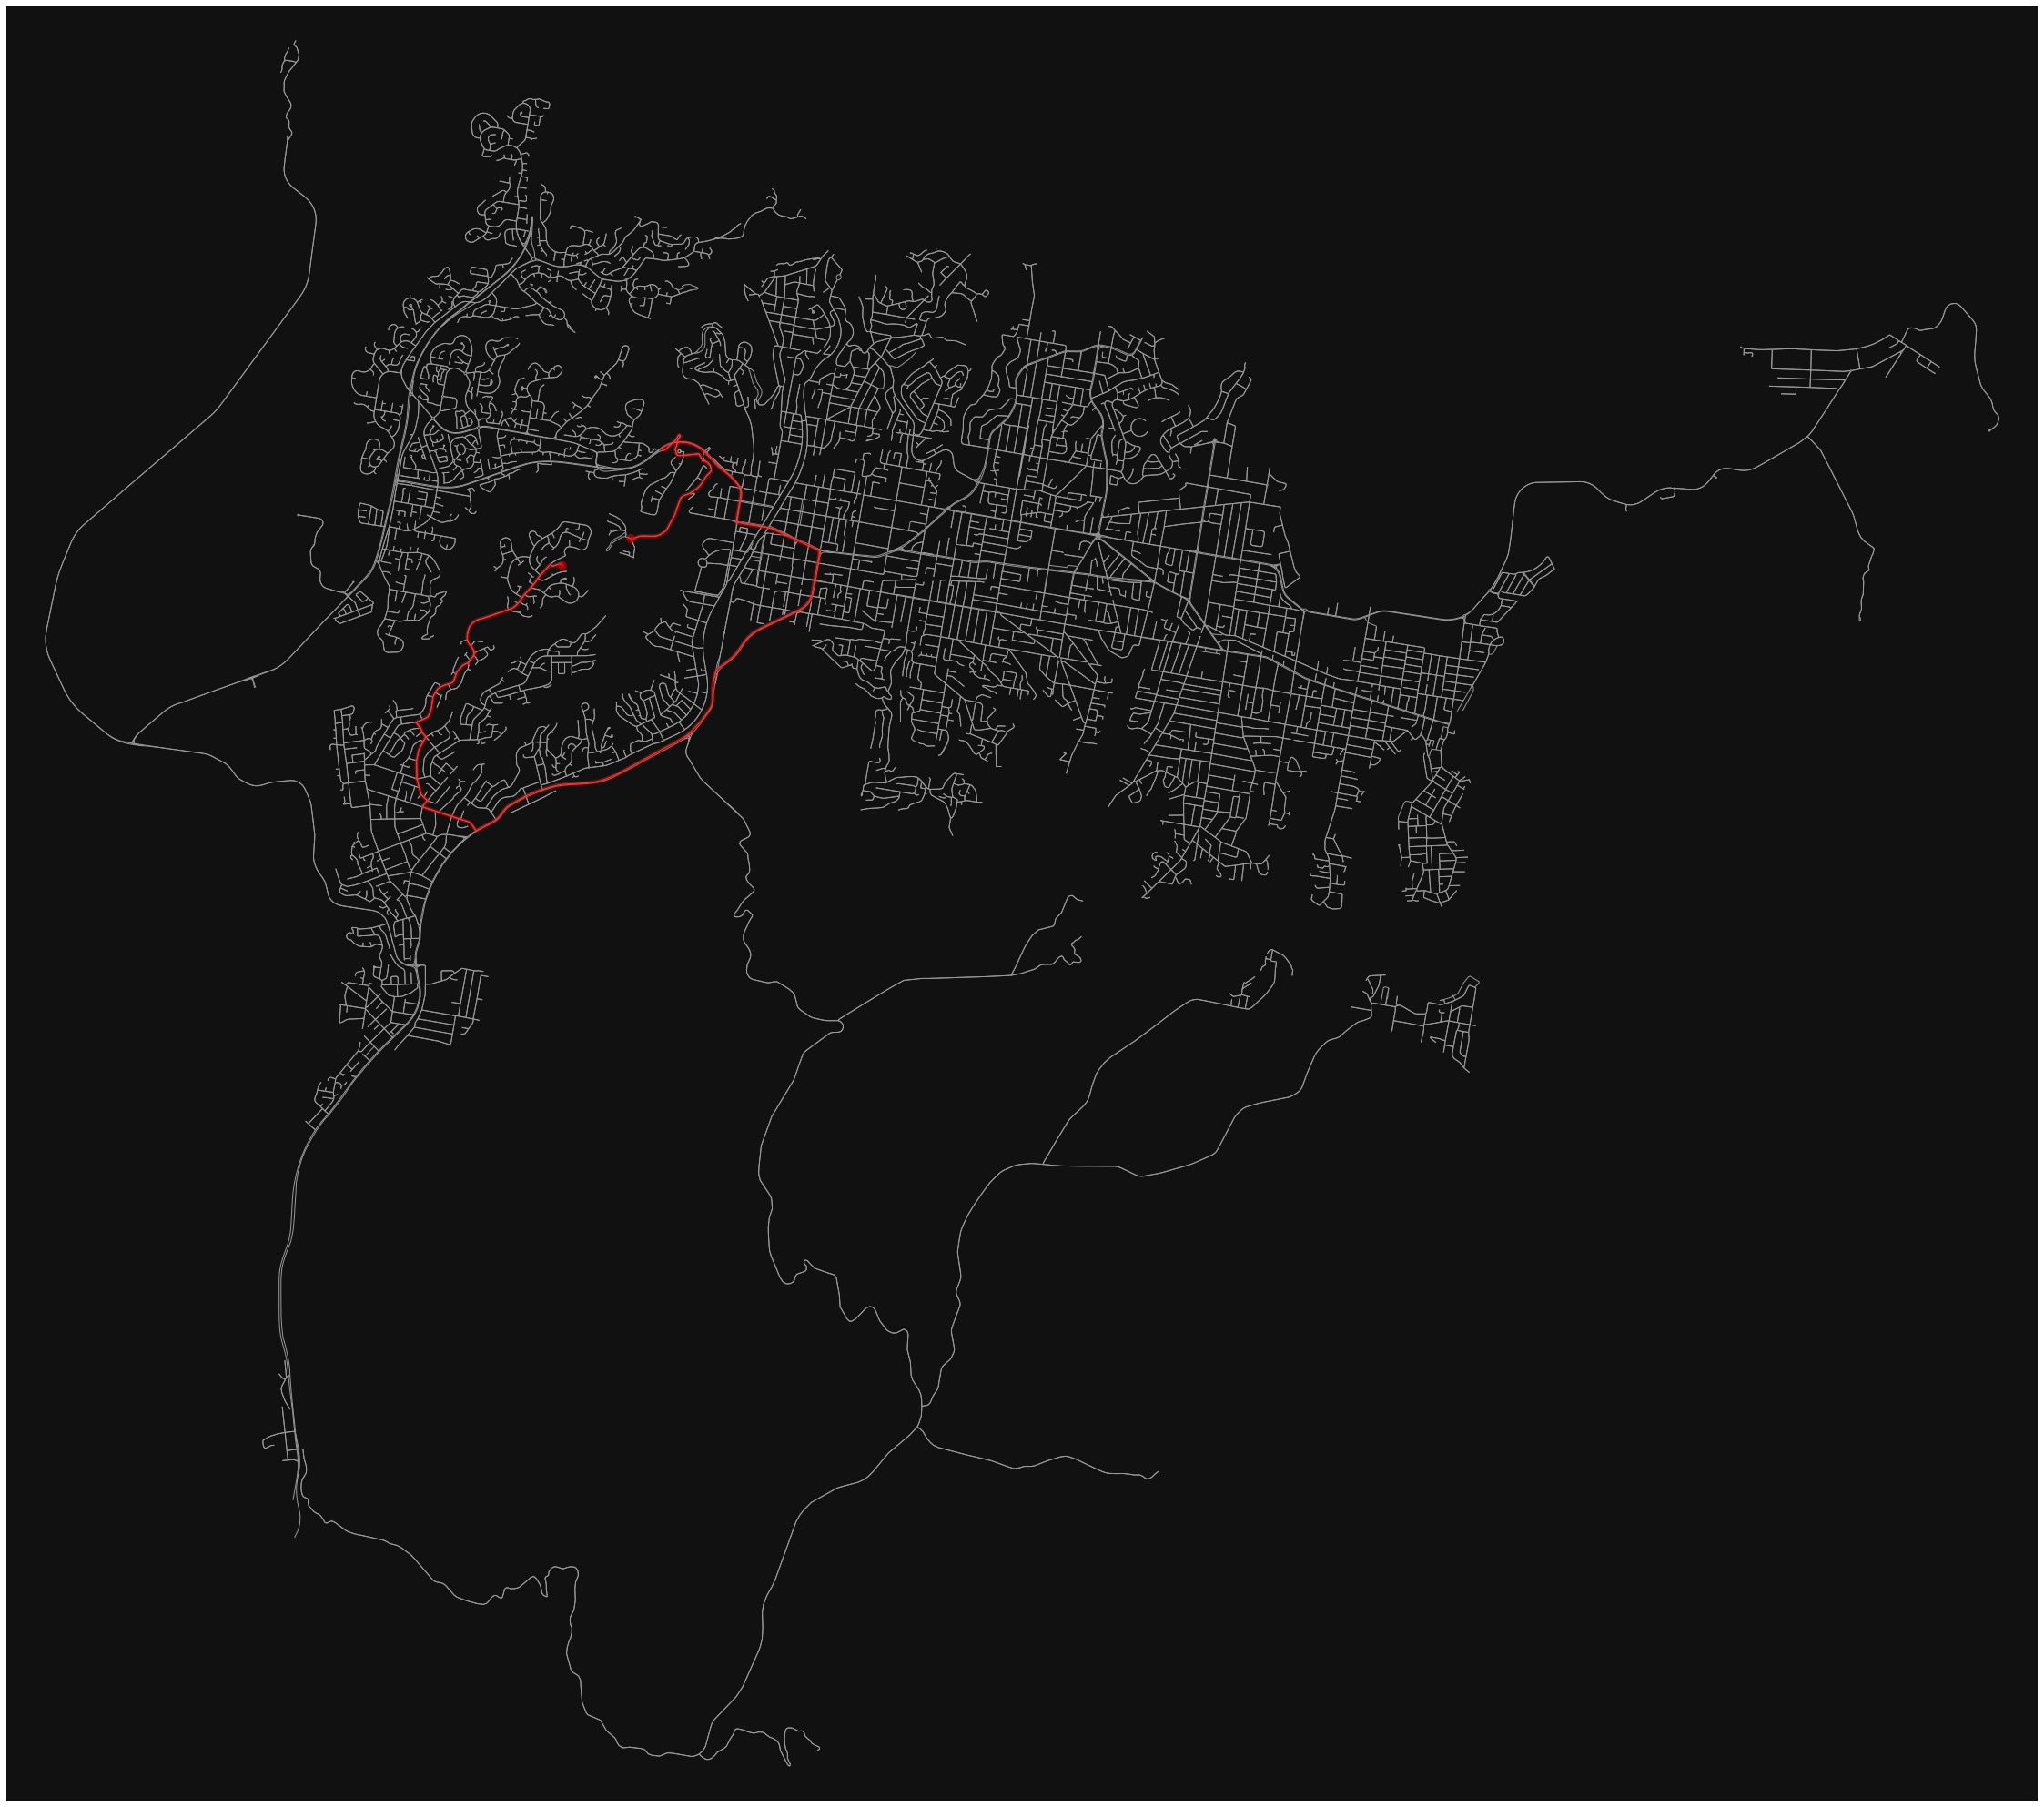

In [25]:
import geopandas as gpd
import networkx as nx

# impute edge (driving) speeds and calculate edge traversal times
G = ox.add_edge_speeds(G)
G = ox.add_edge_travel_times(G)

# convert string address into geographical coordinates
def geocode_address(address, crs=4326):
    geocode = gpd.tools.geocode(address, provider='nominatim', 
                user_agent="drive time demo").to_crs(crs)
    return (geocode.iloc[0].geometry.y, geocode.iloc[0].geometry.x)

# get origin and destination coordinates
origin_point = geocode_address("Whimbrel Place, Woronora Heights, NSW")
destination_point = geocode_address("Prince Edward Park, Woronora, NSW")

# get closes graph nodes to origin and destination
orig_node = ox.distance.nearest_nodes(G, origin_point[1], origin_point[0])
destination_node = ox.distance.nearest_nodes(G, 
    destination_point[1], destination_point[0])

# find shortest path based on travel time
route = nx.shortest_path(G, orig_node, destination_node, weight='travel_time')

fig, ax = ox.plot_graph_route(G, route, node_size=0, figsize=(40,40))

In [26]:
edge_lengths = ox.utils_graph.get_route_edge_attributes(
    G, route, 'length') 
total_route_length = sum(edge_lengths)
print("Total route length in km:", total_route_length/1000)

edge_travel_time = ox.utils_graph.get_route_edge_attributes(
    G, route, 'travel_time') 
route_travel_time = sum(edge_travel_time)
print("Travel time in minutes:", route_travel_time/60)

Total route length in km: 16.78673
Travel time in minutes: 16.895000000000003


# 그래프 세이브

In [27]:
ox.save_graphml(G, 'sutherland_drive.graphml')

# Generate node & edges graph

In [28]:
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects

def show_directions(origin_node_id):
  map_limit_x = 0.0025
  map_limit_y = 0.0015
  fig = plt.figure(figsize=(8,8))
  ax = plt.axes()
  origin_node = G.nodes.get(origin_node_id)

  G2 = nx.generators.ego_graph(G, origin_node_id, radius=6)
  gdf_nodes, gdf_edges = ox.graph_to_gdfs(G2)

  gdf_edges.plot(ax=ax, color="#aaa")
  gdf_nodes.plot(ax=ax, color="r", zorder=12)
  ax.set_xlim(origin_node["x"]-map_limit_x, origin_node["x"]+map_limit_x)
  ax.set_ylim(origin_node["y"]-map_limit_y, origin_node["y"]+map_limit_y)

  for node_id in list(G.neighbors(origin_node_id)) + [origin_node_id]:
    node = G.nodes.get(node_id)
    txt = ax.annotate(text=f"{node_id}", xy=(node["x"]+0.0001,node["y"]+0.0001),
                  horizontalalignment='left', fontsize=10, wrap=True, color='k', zorder=11)
    txt.set_path_effects([PathEffects.withStroke(linewidth=4, foreground='w')])

    if node_id != origin_node_id:
      ax.quiver(origin_node["x"], origin_node["y"], node["x"]-origin_node["x"], node["y"]-origin_node["y"], angles='xy', scale_units='xy', scale=1, zorder=10)

  ax.set_axis_on()

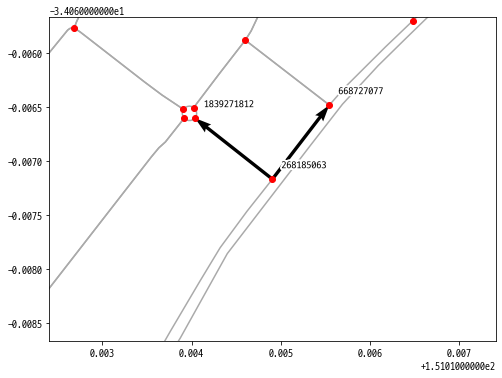

In [29]:

show_directions(station_st_node_id)

# 실습

In [22]:
import osmnx as ox
G2 = ox.graph_from_place('Gangseo-gu',  network_type='drive')

In [23]:
print("node count:", len(G2.nodes()))
print("edge count:", len(G2.edges()))

node count: 3015
edge count: 8614


In [24]:
# find nearest node
node_id = ox.distance.nearest_nodes(G2, [126.8163], [37.5521])[0]
node_id

2353543122

In [25]:
# find node by ID and show its properties
G2.nodes.get(node_id)

{'y': 37.5521562, 'x': 126.8164333, 'street_count': 4}

In [26]:
# find its neighbouring nodes
list(G2.neighbors(node_id))

[2353543113, 4641608323]

In [27]:
import json
# show edge attributes
for edge in G2.out_edges(node_id, data=True):
    print("\n=== Edge ====")
    print("Source and target node ID:", edge[:2])
    edge_attributes = edge[2]
    # remove geometry object from output
    edge_attributes_wo_geometry = {i:edge_attributes[i] for i in edge_attributes if i!='geometry'}
    print("Edge attributes:", json.dumps(edge_attributes_wo_geometry, indent=4))


=== Edge ====
Source and target node ID: (2353543122, 2353543113)
Edge attributes: {
    "osmid": 226544038,
    "oneway": true,
    "ref": "6;77",
    "name": "\ubc29\ud654\ub300\ub85c",
    "highway": "primary",
    "length": 48.695
}

=== Edge ====
Source and target node ID: (2353543122, 4641608323)
Edge attributes: {
    "osmid": 517261840,
    "oneway": true,
    "lanes": "2",
    "name": "\ub0a8\ubd80\uc21c\ud658\ub85c",
    "highway": "primary_link",
    "length": 62.358
}


In [28]:
# impute edge (driving) speeds and calculate edge traversal times
G2 = ox.add_edge_speeds(G2)
G2 = ox.add_edge_travel_times(G2)

In [29]:
orig_node = ox.distance.nearest_nodes(G2, [126.8211], [37.5501])[0]
destination_node = ox.distance.nearest_nodes(G2, [126.8131], [37.5806])[0]
print(orig_node, destination_node)

1791473852 2690891084


In [33]:
route[0]

1791473852

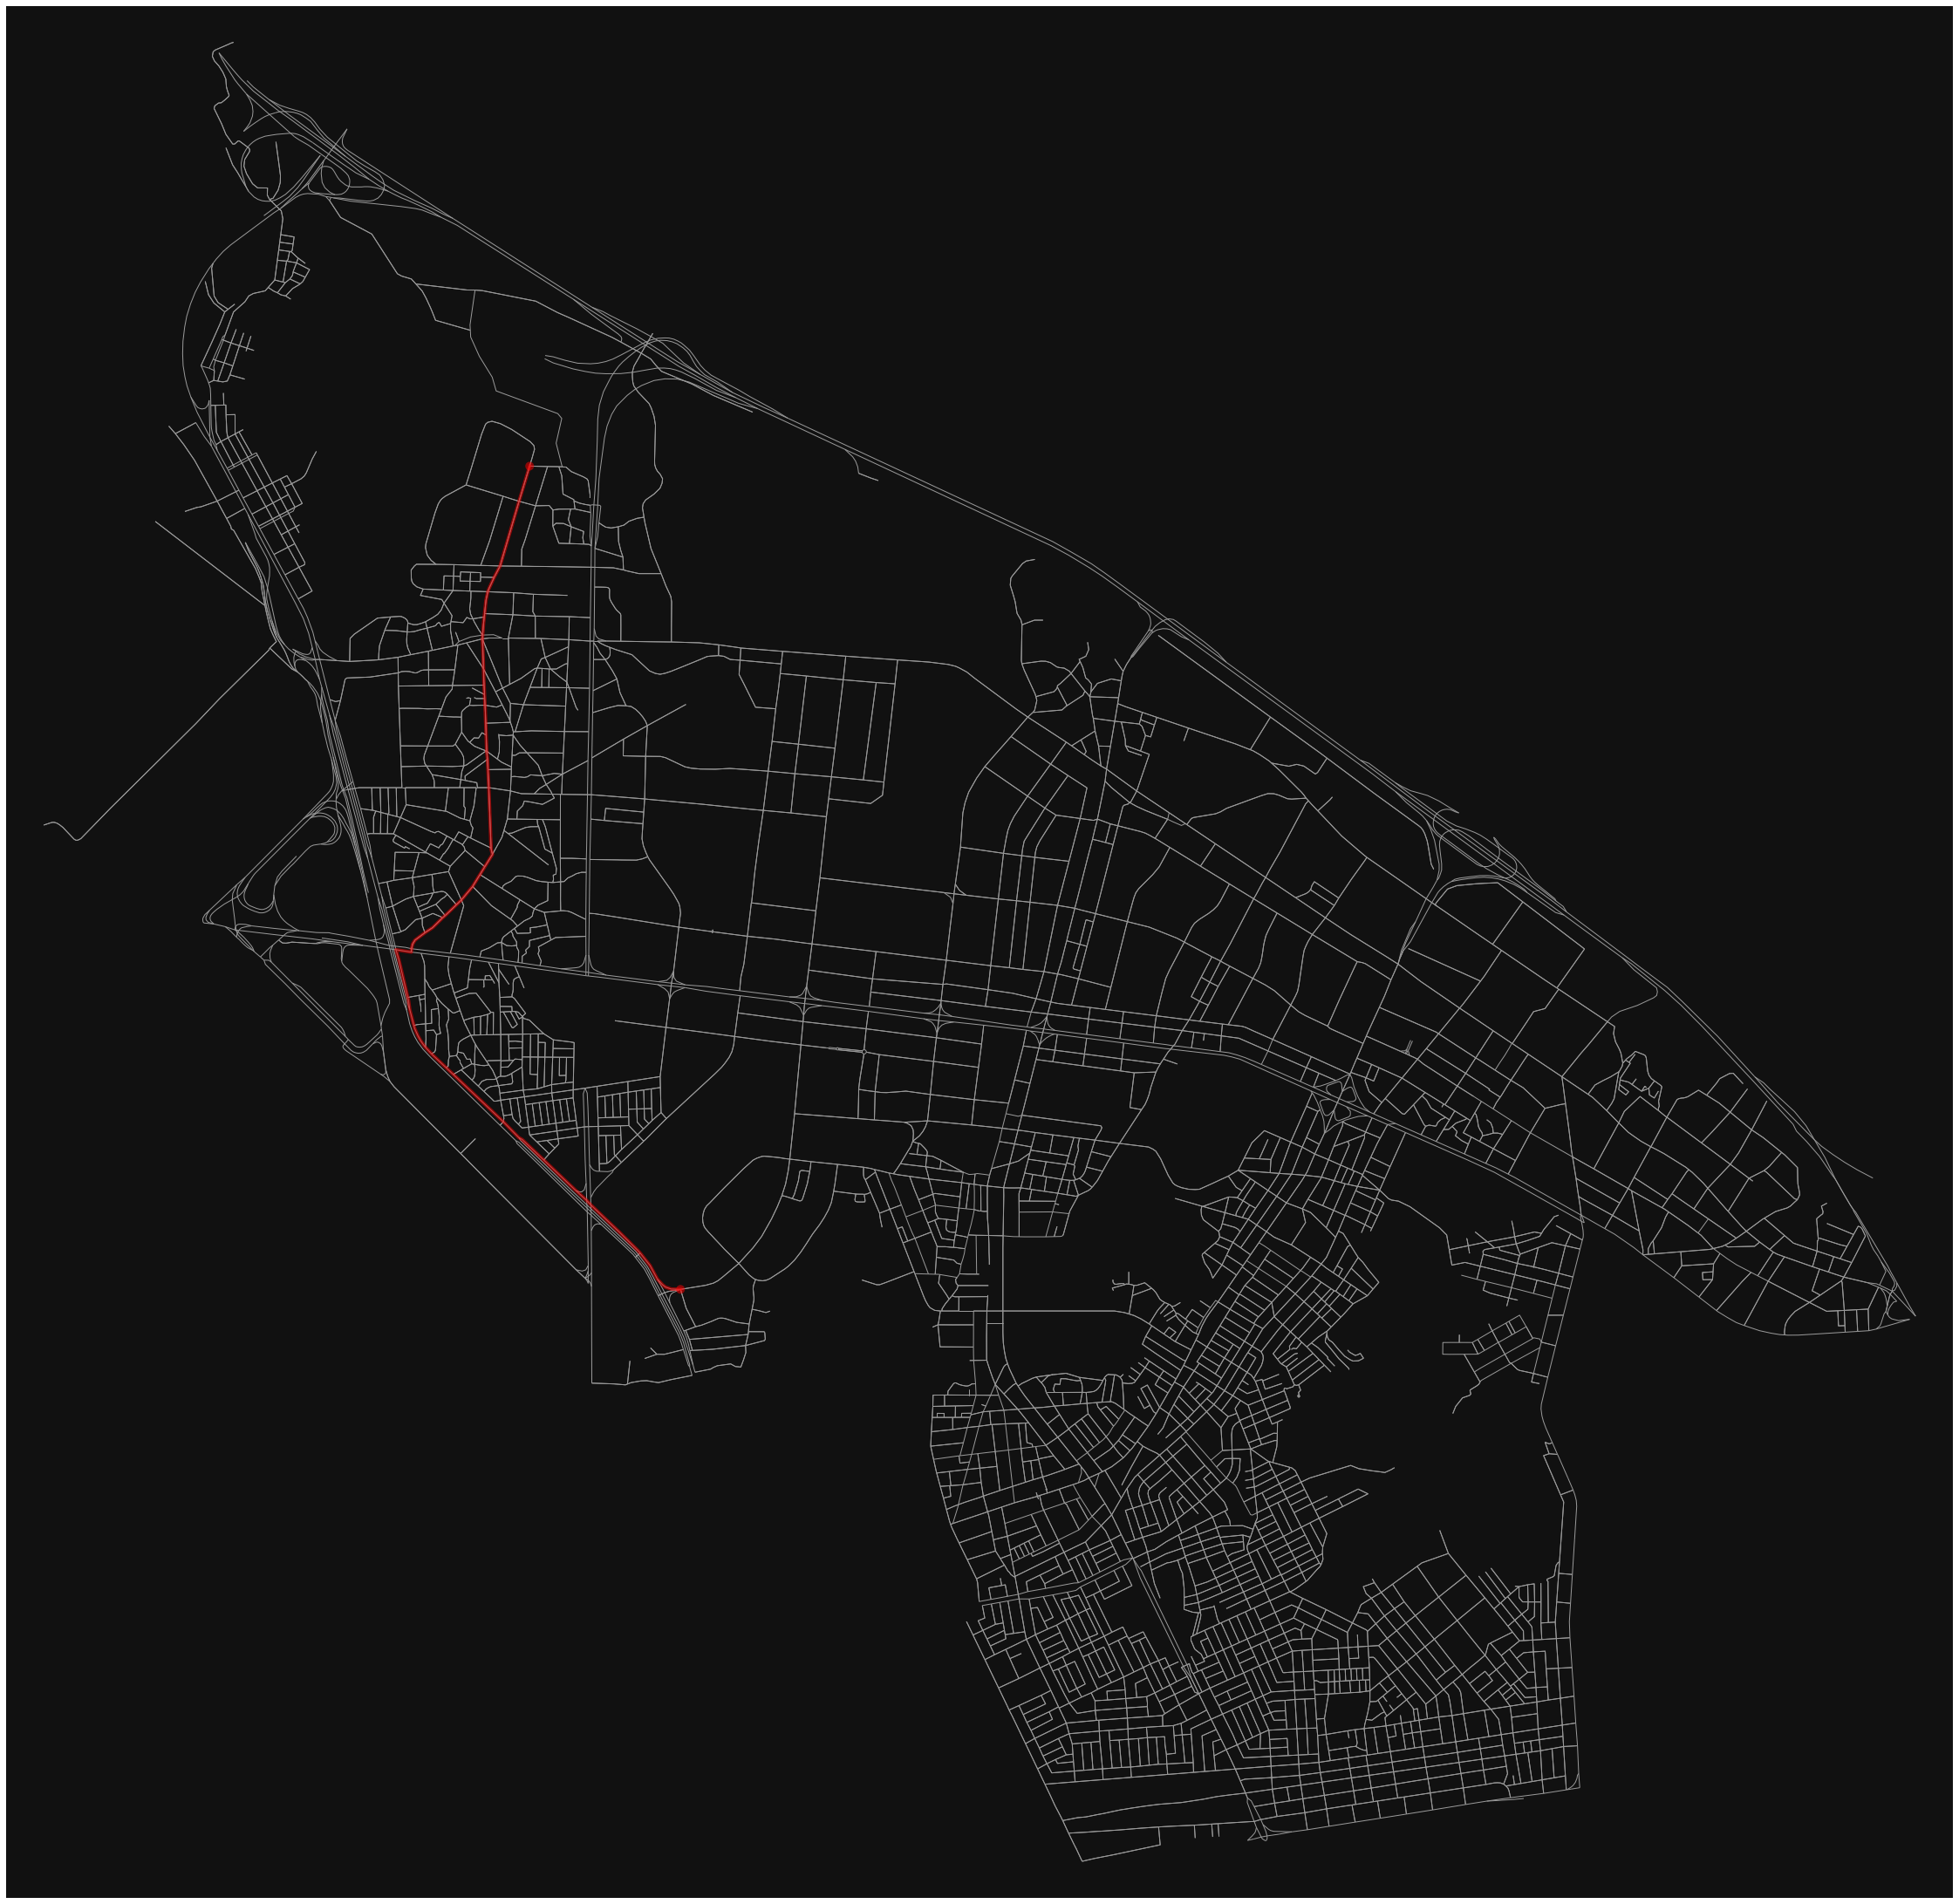

In [30]:
import geopandas as gpd
import networkx as nx
# find shortest path based on travel time
route = nx.shortest_path(G2, orig_node, destination_node, weight='travel_time')

fig, ax = ox.plot_graph_route(G2, route, node_size=0, figsize=(40,40))

In [37]:
route[:5]

[1791473852, 2353374209, 4601063916, 4641608314, 2353543122]

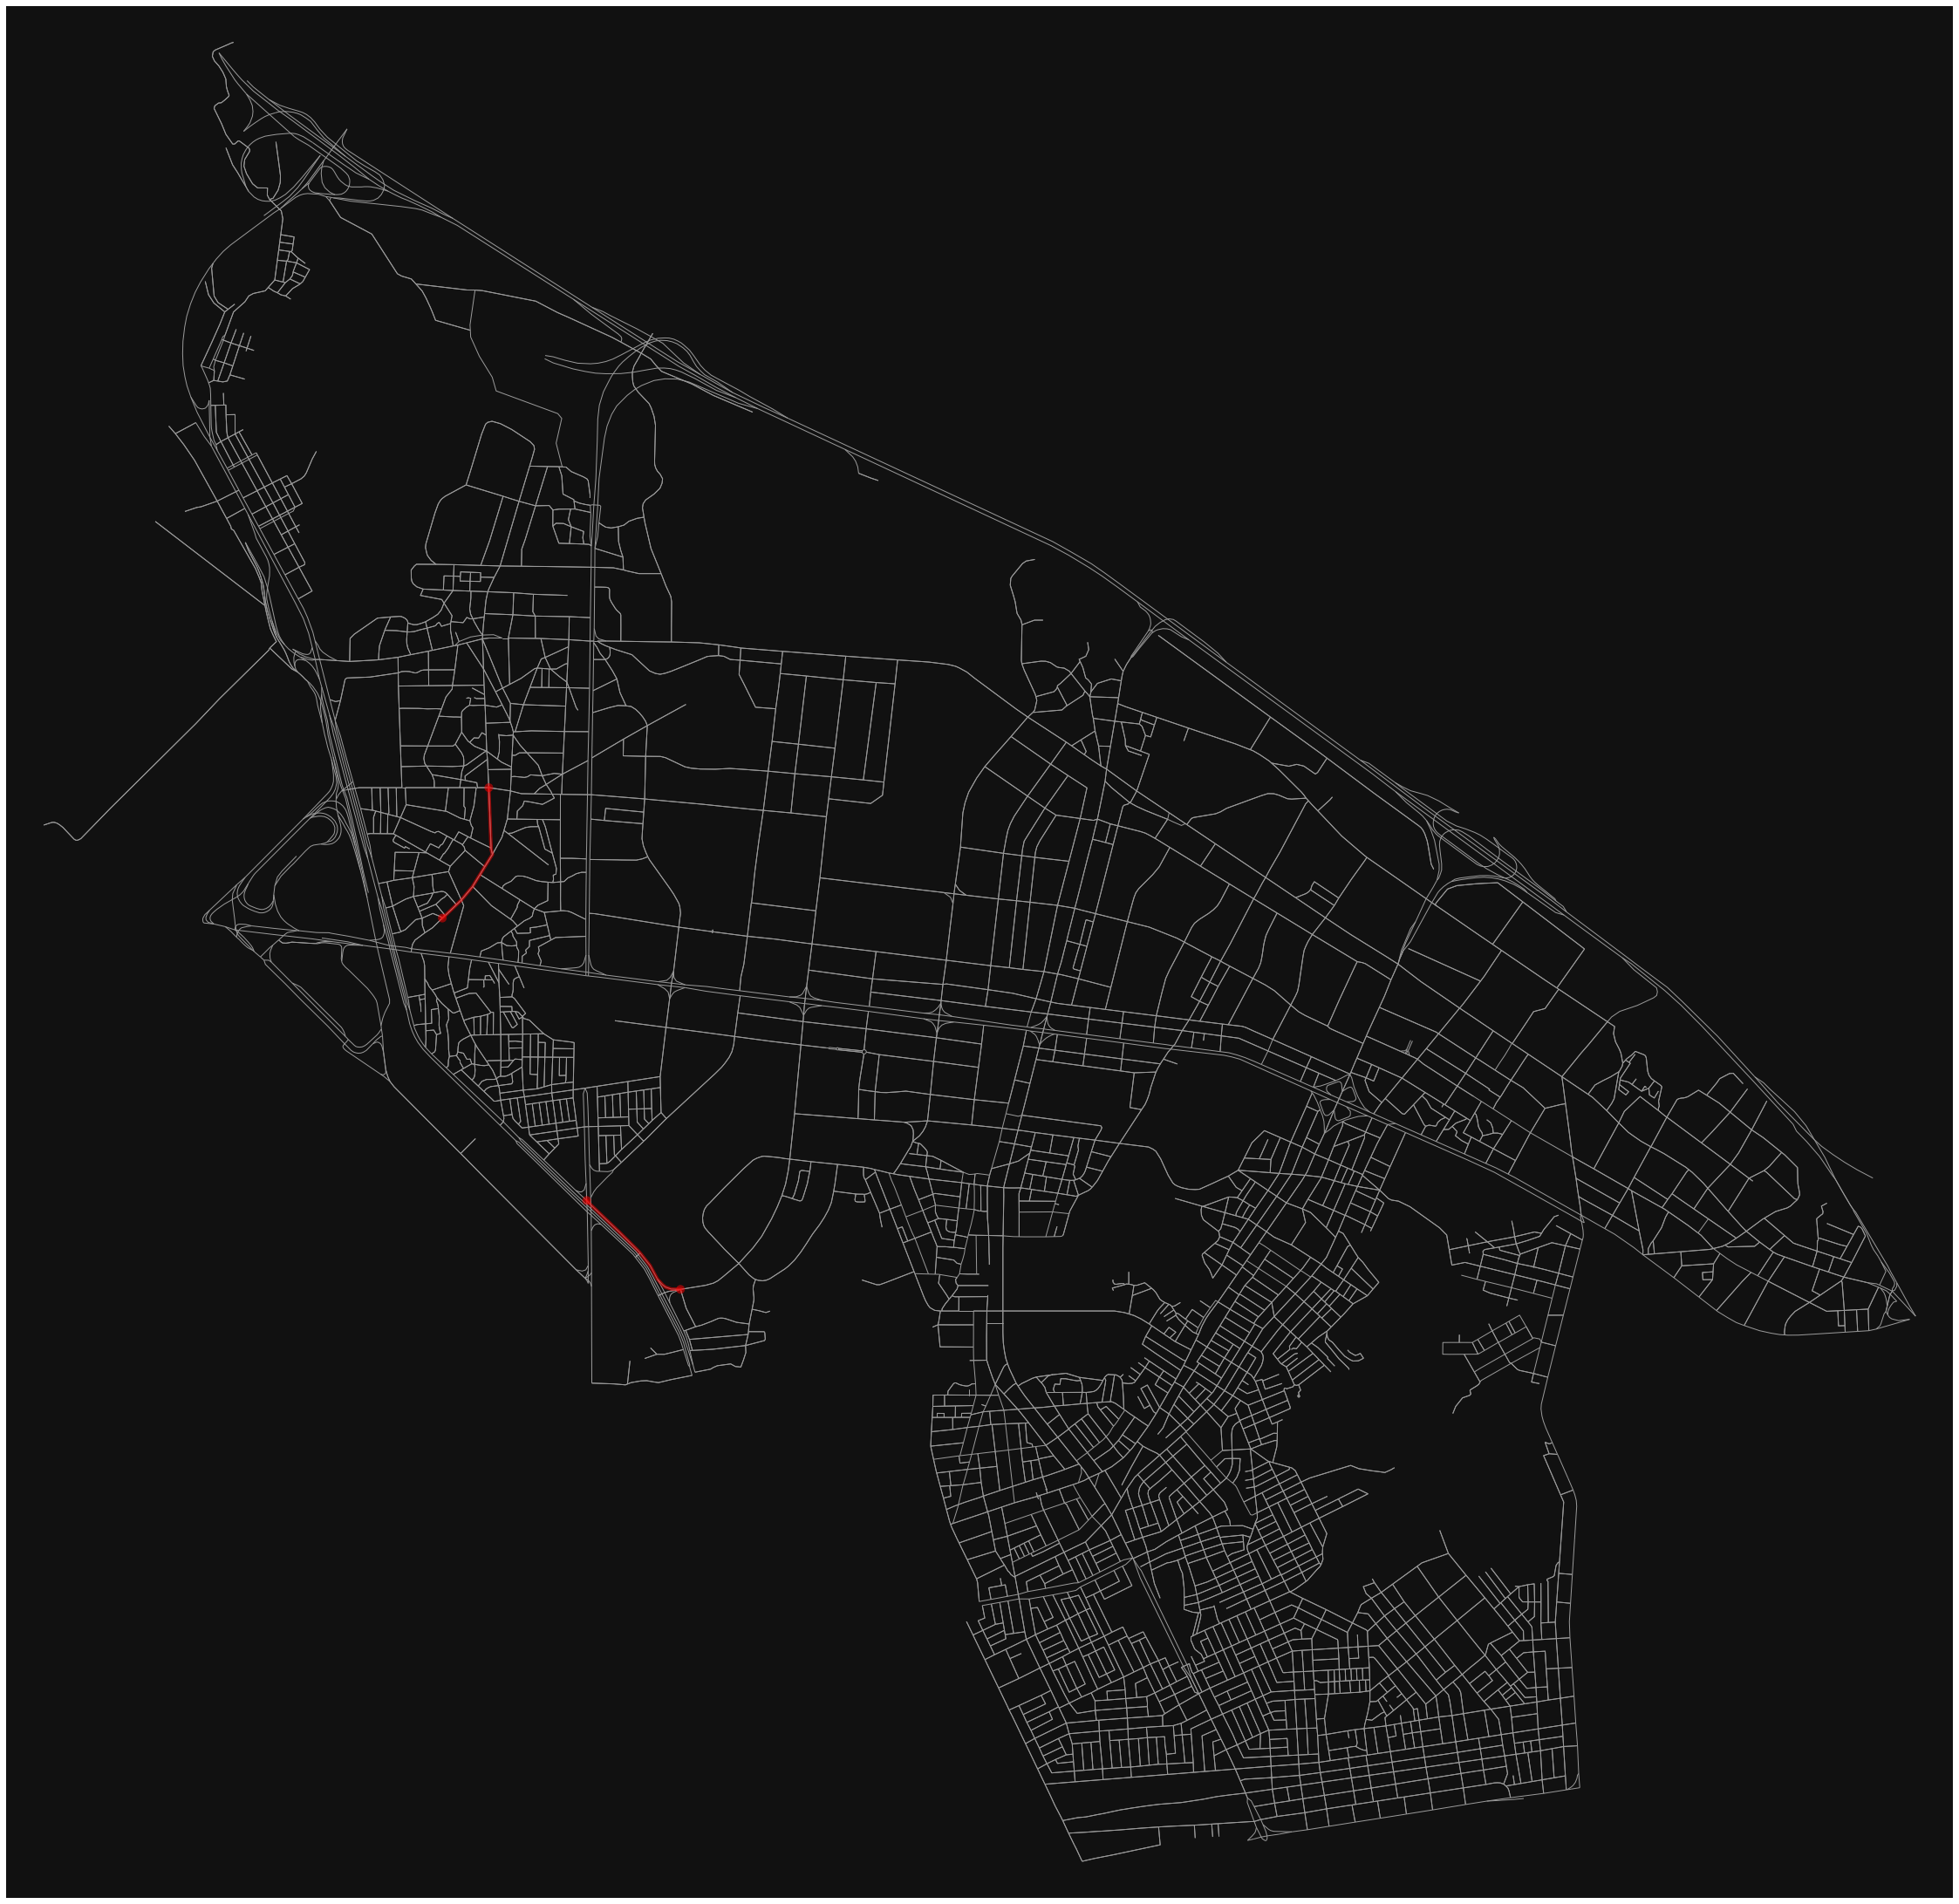

In [60]:
import geopandas as gpd
import networkx as nx
# find shortest path based on travel time
route = nx.shortest_path(G2, orig_node, destination_node, weight='travel_time')

fig, ax = ox.plot_graph_routes(G2, [route[:5], route[20:30]], node_size=0, figsize=(40,40))

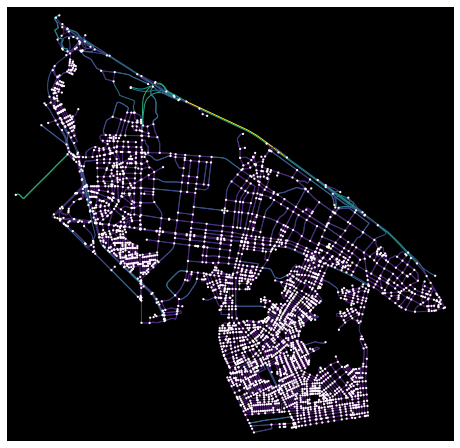

In [63]:
# otherwise, when num_bins is None (default), linearly map 1 color to each node/edge by value
ec = ox.plot.get_edge_colors_by_attr(G2, attr='length')

# plot the graph with colored edges
fig, ax = ox.plot_graph(G2, node_size=5, edge_color=ec, bgcolor='k')